In [99]:
def cleaning_tweets(text):
    ''' Clean tweets with regex patterns
    
    Args : 
        - text : string
    
    Returns : 
        A transformed text
    '''

    text = str(text)
    text = text.lower()

    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"\b[a-zA-Z]\b", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    text = re.sub(r"\s+", " ", text)

    text = text.split()

    return text

In [100]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

df = pd.read_csv('../tweets/tweets_remaining_09042020_16072020.csv', delimiter=';')

df['Date'] = df['created_at'].str.split().str[0]

df = df[df['text'].str.contains("meta")]

sia = SentimentIntensityAnalyzer()

df['Sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

sentiment_df = df[['Date', 'Sentiment']]

average_sentiment_df = sentiment_df.groupby('Date').mean().reset_index()

print(average_sentiment_df)


          Date  Sentiment
0   2020-04-09   0.103475
1   2020-04-10   0.091038
2   2020-04-11   0.207946
3   2020-04-12   0.145742
4   2020-04-13   0.033800
..         ...        ...
72  2020-07-12   0.338092
73  2020-07-13   0.087425
74  2020-07-14  -0.032058
75  2020-07-15   0.030073
76  2020-07-16  -0.077120

[77 rows x 2 columns]


In [101]:
import yfinance as yf
meta_df = yf.download("meta", start="2020-04-09", end="2020-07-16", progress=False)

In [102]:
average_sentiment_df['Date'] = pd.to_datetime(average_sentiment_df['Date'])


average_sentiment_df = average_sentiment_df[average_sentiment_df['Date'].isin(meta_df.index)]
meta_df = meta_df[meta_df.index.isin(average_sentiment_df['Date'])]
average_sentiment_df = average_sentiment_df.reset_index(drop=True)
meta_df = meta_df.reset_index(drop=True)

In [103]:
meta_df['Sentiment'] = average_sentiment_df['Sentiment'].to_numpy()

In [104]:
meta_df["Tomorrow"] = meta_df["Close"].shift(-1)

In [105]:
meta_df["Target"] = (meta_df["Tomorrow"] > meta_df["Close"]).astype(int)


## Random Forest

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(meta_df[['Open', 'High', 'Low', 'Close',
'Adj Close', 'Volume', 'Sentiment']], meta_df['Target'], test_size=0.2, random_state=42, shuffle=False)


model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

test_df = meta_df[meta_df.index.isin(X_test.index)]

test_df['Predictions'] = y_pred


/var/folders/9f/tqhf2_lj7x9g9w7kvpf8_91r0000gn/T/ipykernel_78362/3245676496.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predictions'] = y_pred


In [107]:
test_df = test_df.reset_index(drop=True)


In [108]:
wallet = 10000
wallet_value = []  
for i in range(len(test_df)):
    if (test_df['Predictions'][i] == 1) and (test_df['Target'][i] == 1):
        wallet += (test_df['Tomorrow'][i] - test_df['Adj Close'][i])
    elif (test_df['Predictions'][i] == 0) and (test_df['Target'][i] == 0):
        wallet += (test_df['Adj Close'][i] - test_df['Tomorrow'][i])
    else:
        wallet -= abs((test_df['Tomorrow'][i] - test_df['Adj Close'][i]))
    wallet_value.append(wallet)

test_df['Wallet'] = wallet_value

          Open        High         Low       Close   Adj Close    Volume   
0     0.000000    0.000000    0.000000    0.000000    0.000000         0  \
1   220.589996  227.500000  218.470001  227.070007  226.829346  33927100   
2   228.500000  239.000000  227.559998  237.550003  237.298233  43399700   
3   239.000000  240.000000  232.610001  233.419998  233.172592  30633600   
4   233.759995  240.399994  232.270004  240.279999  240.025330  26206200   
5   239.410004  247.649994  238.820007  240.860001  240.604721  27887800   
6   238.110001  246.990005  236.589996  243.580002  243.321838  29791300   
7   245.000000  246.529999  239.240005  244.500000  244.240860  22174900   
8   243.690002  245.490005  239.320007  245.070007  244.810257  22982700   
9   247.009995  250.149994  238.419998  239.000000  238.746689  24674900   
10  236.759995  240.330002  232.029999  239.729996  239.475906  23378100   
11  241.550003  244.820007  238.050003  240.279999  240.025330  19133600   

    Sentime

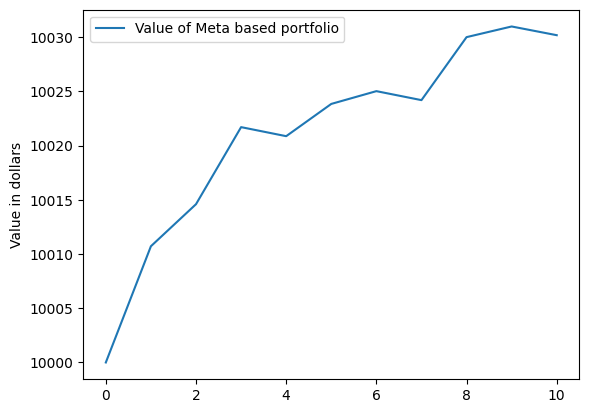

In [109]:
wallet_df = test_df.copy()
wallet_df = wallet_df.drop(wallet_df.index[0:60])

wallet_df.loc[-1] = [0] * len(wallet_df.columns)
wallet_df.index = wallet_df.index + 1
wallet_df = wallet_df.sort_index()
wallet_df.loc[0, 'Wallet'] = 10000


wallet_df = wallet_df.reset_index(drop=True)
wallet_df = pd.concat([wallet_df, test_df], ignore_index=True)


print(wallet_df)

plt.plot(wallet_df['Wallet'], label='Value of Meta based portfolio')
plt.ylabel('Value in dollars')
plt.legend()
plt.show()



In [110]:
# Printing the return
print((wallet_df['Wallet'][len(wallet_df)-2] - wallet_df['Wallet'][0])/wallet_df['Wallet'][0]*100)


0.30185394287109374
